# 引入库

In [1]:
import keras
import os
import shutil
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from mylibs.ProcessBar import ShowProcess
from mylibs import funs
keras.__version__

Using TensorFlow backend.


'2.2.4'

# 猫狗分类实验
## 实验目的
创建一个简单图像二分类的卷积模型,掌握以下知识点：
* 数据生成器的使用方法
    ./MyDL/Tensorflow/demo/python/demo_ImageDataGenerator2.py
* 卷积神经网络模型创建：卷积层，密度层，激活函数，损失函数，优化函数
* 模型训练方法
* 模型预测方法
* plt基本使用方法
* 训练曲线绘制
* 可视化FeatureMap
* 可视化神经网络的过滤器
* 可视化类激活的热力图

本实验的数据将作为基础参考

## 实验数据说明
  * 网络数据下载地址：https://www.kaggle.com/c/dogs-vs-cats/data
  * 本地数据存储路径：~/e/dataset_tiptical/cats_and_dogs
  * 实验数据根目录：~/data/cats_and_dogs
      - ./ori      ------------猫狗分类原始数据目录
      - ./lab_base ------------实验方案目录
      - ./lab_base/train ------训练目录
      - ./lab_base/valid ------校验目录
      - ./lab_base/test  ------测试目录
      - ./lab_base/test.jpg ---测试图片
      

## 参考资料
visualization of filters keras 基于Keras的卷积神经网络（CNN）可视化

http://www.cnblogs.com/bnuvincent/p/9612686.html

python深度学习{eep learning with python中文版.pdf}源码

https://github.com/fchollet/deep-learning-with-python-notebooks

数据下载：

https://www.kaggle.com/c/dogs-vs-cats/data

本地数据

~/e/dataset_tiptical/cats_and_dogs


# 基本参数

In [7]:
data_path='%s/data/cats_and_dogs'%(os.getenv('HOME')) #猫狗分类数据根目录
ori_path='%s/ori'%(data_path)                         #猫狗分类原始文件目录
lab_path='%s/lab_base'%(data_path)                    #实验方案目录
split_num="0.6,0.2,0.2"                               #实验数据分割方案,<1：比例分割，>1：数量分割
batch_size=32                                         #批量大小
data_enhance=False                                    #ImageDataGenerator数据启用数据增强
epochs=5                                            #训练轮次
img_width=150                                         #训练图像宽度
img_height=150                                        #训练图像高度 
test_img_path='%s/test.jpg'%(data_path)               #测试图片路径

#网络可视化参数
images_per_row=16       #图像显示每行显示的单元个数
feature_map_top_num=8   #FeatureMap前面N层{include_top=False}
img_margin=3            #图像单元空隙
layers_name=['conv2d_1','conv2d_2','conv2d_3','conv2d_4'] #卷积层名称
gen_pat_steps=40        #构造迭代次数

# 通用函数

In [8]:
#数据生成器
def DataGen(from_path,to_path,split_num,img_width=150,img_height=150,batch_size=32,enhance=False):
    '''数据生成器
    @param from_path  源目录，图像以类别名称建立子目录存储，如“cat,dog”
    @param to_path    训练目录,从from_path提取文件存放在to_path对应目录
    @param split_num  训练，校验，测试分集比例(<1)或个数(>1)，如："0.6,0.2,0.2"或"100,20,20"    
    @param img_width  生成图像宽度
    @param img_height 生成图像高度
    @param enhance    是否使用数据增强
    使用范例：
        (train_gen,valid_gen,test_gen)=DataGen("./from","./to","0.6,0.2,0.2",150,150,False)
        或
        (train_gen,valid_gen,test_gen)=DataGen("./from","./to","100,20,20",150,150,False)
        -------
        数据范例：
        源目录：
            ./from_path/cats/*
            ./from_path/dogs/*
        目的目录：
            ./to_path/train/cats/*
            ./to_path/train/dogs/*
            ./to_path/valid/cats/*
            ./to_path/valid/dogs/*
            ./to_path/test/cats/*
            ./to_path/test/dogs/*
    '''
    #图像分集
    funs.images_split(from_path,to_path,"train,valid,test",split_num)
    
    #数据生成器
    if enhance:
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,)        
        
    else:
        train_datagen = ImageDataGenerator(rescale=1./255)
        
    valid_datagen = ImageDataGenerator(rescale=1./255)
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(
            # This is the target directory
            '%s/train'%(to_path),
            # All images will be resized to 150x150
            target_size=(img_height, img_width),
            batch_size=batch_size,
            # Since we use binary_crossentropy loss, we need binary labels
            class_mode='binary')    
    
    valid_generator = test_datagen.flow_from_directory(
            '%s/valid'%(to_path),
            target_size=(img_height, img_width),
            batch_size=batch_size,
            class_mode='binary')    
    
    test_generator = test_datagen.flow_from_directory(
            '%s/test'%(to_path),
            target_size=(img_height, img_width),
            batch_size=batch_size,
            class_mode='binary')
    return (train_generator,valid_generator,test_generator)

#FeatureMap可视化
def ViewFeatureMap():
    pass

# 加载数据

In [9]:
#删除lab_path
shutil.rmtree(lab_path) if os.path.exists(lab_path) else ''
#数据生成器
(train_gen,valid_gen,test_gen)=DataGen(ori_path,lab_path,split_num
                                       ,img_width=img_width,img_height=img_height
                                       ,batch_size=batch_size,enhance=data_enhance)

Found 15000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


# 创建模型

In [10]:
#创建模型
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(img_height, img_width, 3),name='conv2d_1'))
model.add(layers.MaxPooling2D((2, 2),name='max_pooling2d_1'))
model.add(layers.Conv2D(64, (3, 3), activation='relu',name='conv2d_2'))
model.add(layers.MaxPooling2D((2, 2),name='max_pooling2d_2'))
model.add(layers.Conv2D(128, (3, 3), activation='relu',name='conv2d_3'))
model.add(layers.MaxPooling2D((2, 2),name='max_pooling2d_3'))
model.add(layers.Conv2D(128, (3, 3), activation='relu',name='conv2d_4'))
model.add(layers.MaxPooling2D((2, 2),name='max_pooling2d_4'))
model.add(layers.Flatten(name='flatten_1'))
model.add(layers.Dense(512, activation='relu',name='dense_1'))
model.add(layers.Dense(1, activation='sigmoid',name='dense_2'))    
#打印模型
model.summary()
#模型编译
model.compile(loss='binary_crossentropy',
          optimizer=optimizers.RMSprop(lr=1e-4),
          metrics=['acc'])    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

# 模型训练

In [11]:
#模型训练
print('training beginning ......')
history = model.fit_generator(
  train_gen,
  steps_per_epoch=np.ceil(train_gen.samples/batch_size),
  epochs=epochs,
  validation_data=valid_gen,
  validation_steps=50)    

training beginning ......
Epoch 1/5
469/469 [==============================] - 25s 53ms/step - loss: 0.6171 - acc: 0.6458 - val_loss: 0.5319 - val_acc: 0.7269
Epoch 2/5
469/469 [==============================] - 24s 52ms/step - loss: 0.5316 - acc: 0.7311 - val_loss: 0.4957 - val_acc: 0.7544
Epoch 3/5
469/469 [==============================] - 24s 52ms/step - loss: 0.4793 - acc: 0.7697 - val_loss: 0.4926 - val_acc: 0.7594
Epoch 4/5
469/469 [==============================] - 25s 53ms/step - loss: 0.4346 - acc: 0.7991 - val_loss: 0.4845 - val_acc: 0.7684
Epoch 5/5
469/469 [==============================] - 25s 53ms/step - loss: 0.4053 - acc: 0.8147 - val_loss: 0.4078 - val_acc: 0.8169


# 模型测试

In [12]:
#模型测试
print('predicting beginning ......')
#type(y_pred)=> <class 'numpy.ndarray'>
y_pred=model.predict_generator(
    test_gen, 
    steps=None, #预测轮数
    max_queue_size=32, 
    workers=1, 
    use_multiprocessing=False, 
    verbose=1)

predicting beginning ......
157/157 [==============================] - 8s 51ms/step


# 实验结果-训练曲线

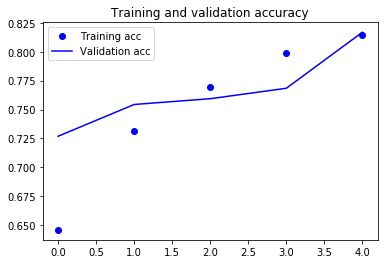

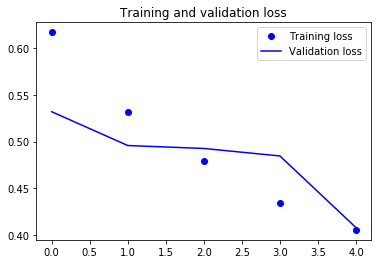

In [13]:
#训练曲线
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 测试图像

(1, 150, 150, 3)


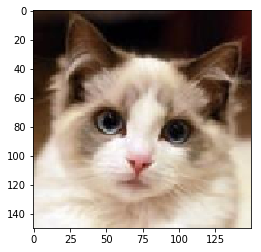

In [14]:
img = image.load_img(test_img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)
plt.imshow(img_tensor[0])
plt.show()

# FeatureMap视图

/home/hjw/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


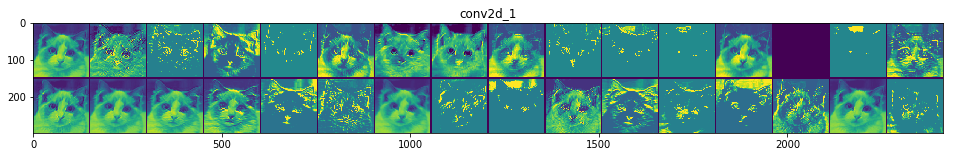

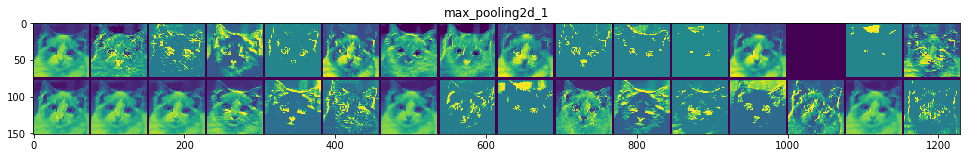

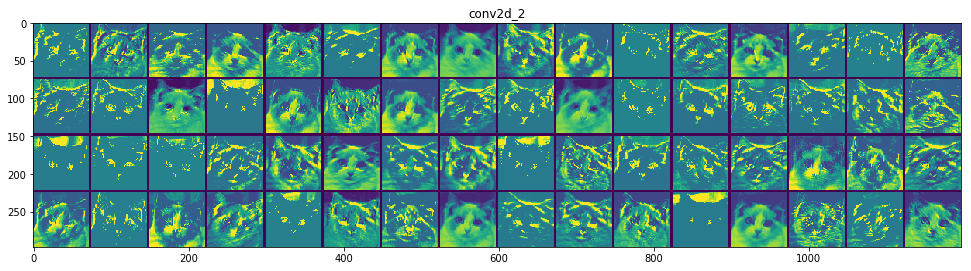

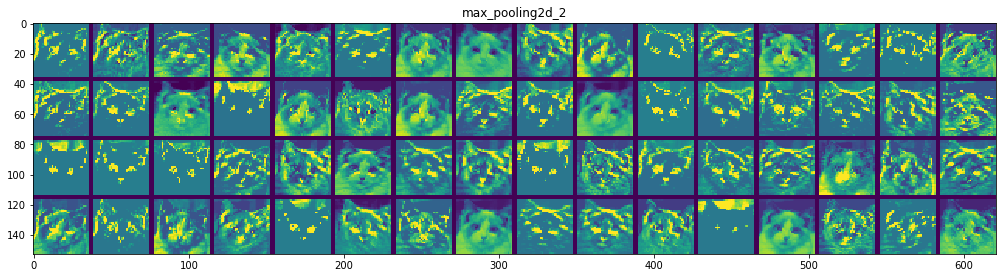

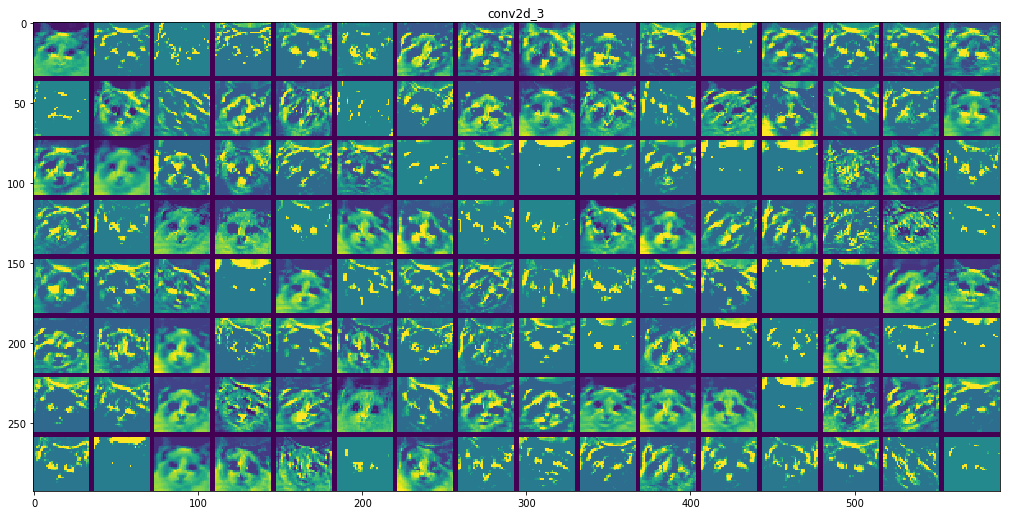

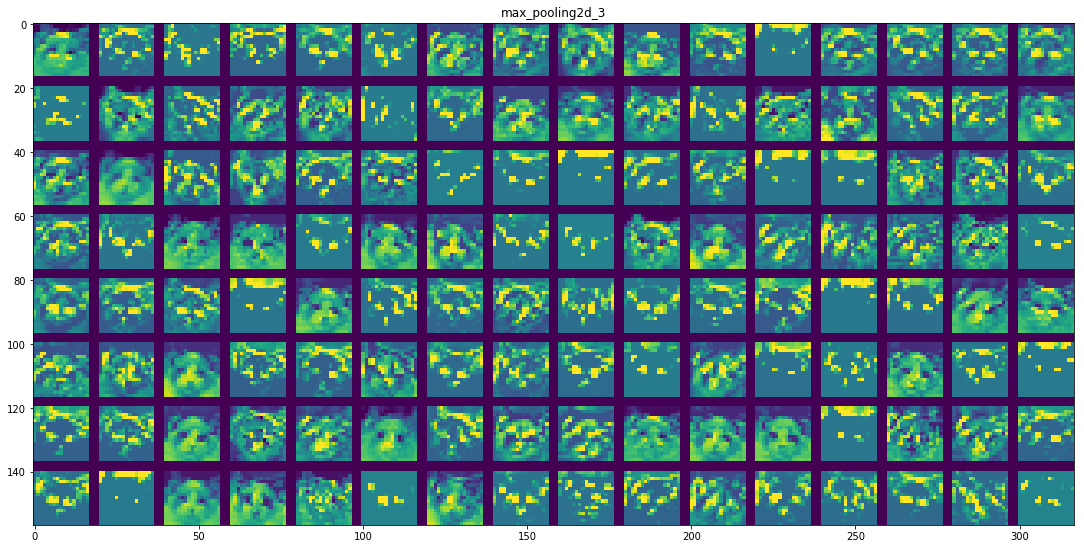

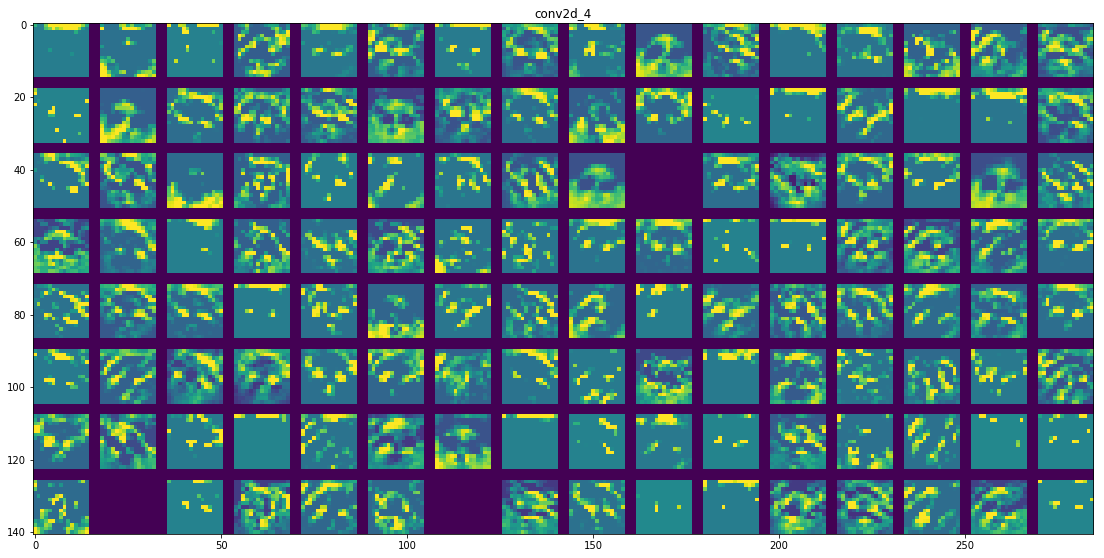

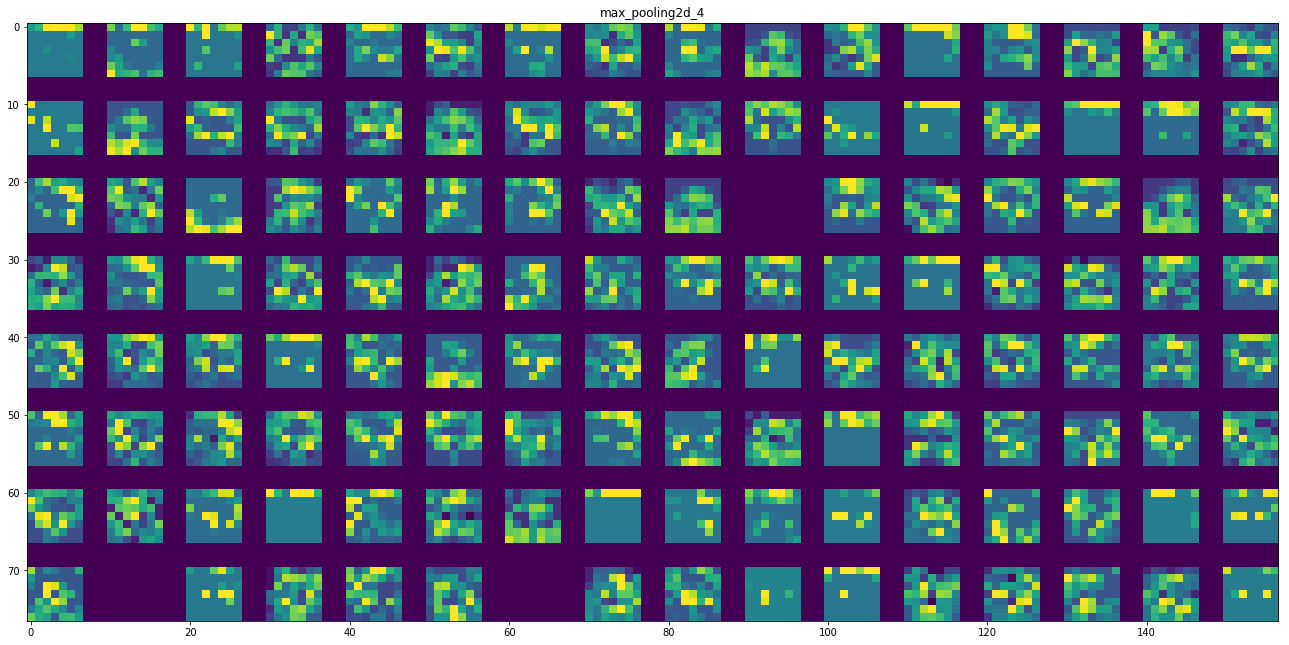

In [15]:
#FeatureMap视图
layer_outputs = [layer.output for layer in model.layers[:feature_map_top_num]]         #前面N个输出层
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) #前面N层输出模型
activations = activation_model.predict(img_tensor)                         #前面N层模型预测
layer_names = []  #前面N层名称
for layer in model.layers[:feature_map_top_num]:
    layer_names.append(layer.name)
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1] #卷积核个数

    # The feature map has shape (1, size, size, n_features)
    size_width = layer_activation.shape[2]        #FeatureMap大小
    size_height = layer_activation.shape[1]        #FeatureMap大小

    # We will tile the activation channels in this matrix
    rows = n_features // images_per_row   #图像单元行数
    cols=images_per_row                   #图像单元列数
    
    #初始化图像网格[rows{height} x cols{width}]
    display_grid = np.zeros((rows*size_height+(rows-1)*img_margin, cols * size_width+(cols-1)*img_margin))  

    # We'll tile each filter into this big horizontal grid
    #把FeatureMap按顺序显示在大图网格，每行images_per_row个FeatureMap
    for row in range(rows):
        for col in range(cols):
            #提取FeatureMap
            channel_image = layer_activation[0,
                                             :, :,
                                             row * cols + col]
            # Post-process the feature to make it visually palatable
            #FeatureMap显示优化处理
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            #把FeatureMap拷贝到相应图像单元区间
            row_start=row*size_height+row*img_margin
            row_end=row_start+size_height
            col_start=col*size_width+col*img_margin
            col_end=col_start+size_width
            #print(display_grid.shape)
            #print('row_start:%d,row_end:%d,col_start:%d,col_end:%d'%(row_start,row_end,col_start,col_end))
            display_grid[row_start : row_end,col_start:col_end] = channel_image

    # Display the grid
    plt.figure(figsize=(1./size_width  * display_grid.shape[1], #width
                        1./size_height * display_grid.shape[0]))#height
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')    
    
plt.show()

# 可视化卷积神经网络的过滤器

In [16]:
#把数据图像化输出
def deprocess_image(x):
    '''数据图像化输出
    @param x  数据
    @return   图像化输出结果
    处理流程：
        1. x归一化处理：mean=0,std=0.1
        2. x整体抬升0.5,并作[0,1]裁剪
        3. x整体乘于255,并作[0,255]裁剪
    '''
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

#生成过滤器的最大化输入
def generate_pattern(model,layer_name, filter_index,steps=40, img_width=150,img_height=150):
    '''生成过滤器的最大化输入
    @param model        网络模型
    @param layer_name   网络层名称，通过名称获取网络层
    @param filter_index 卷积核索引
    @param steps        构造迭代次数
    @param img_width    网络输入图像宽度
    @param img_height   网络输入图像高度
    @return 网络输入图像数据
    '''
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output  #网络层输出
    loss = K.mean(layer_output[:, :, :, filter_index]) #构造损失函数

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]          #梯度计算

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)  #梯度归一化处理

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads]) #迭代函数
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, img_height, img_width, 3)) * 20 + 128. #初始化网络输入图像

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(steps):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

Generating layer of conv2d_1 ......
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]
Done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


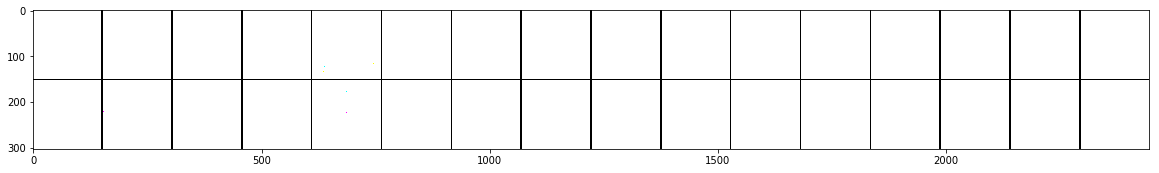

Generating layer of conv2d_2 ......


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Done


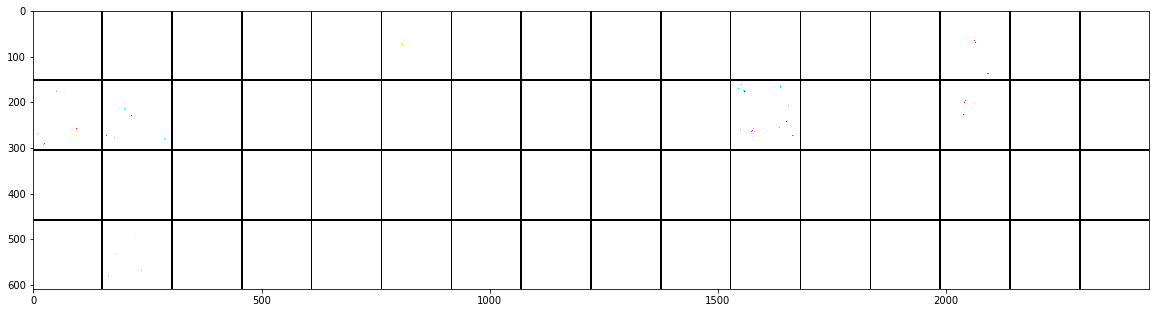

Generating layer of conv2d_3 ......


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Done


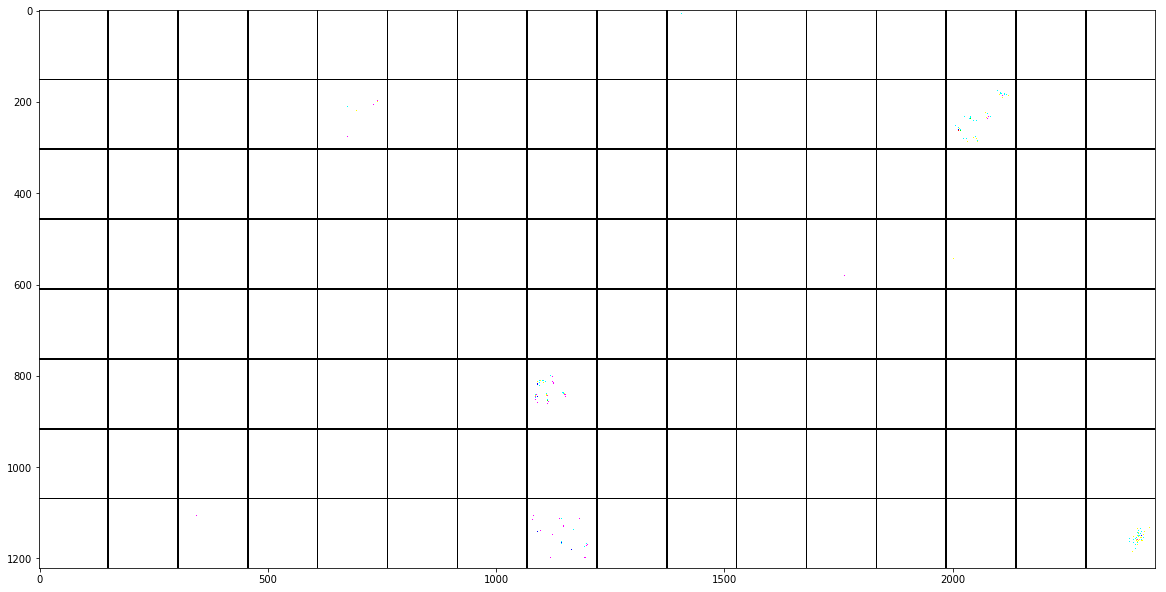

Generating layer of conv2d_4 ......


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Done


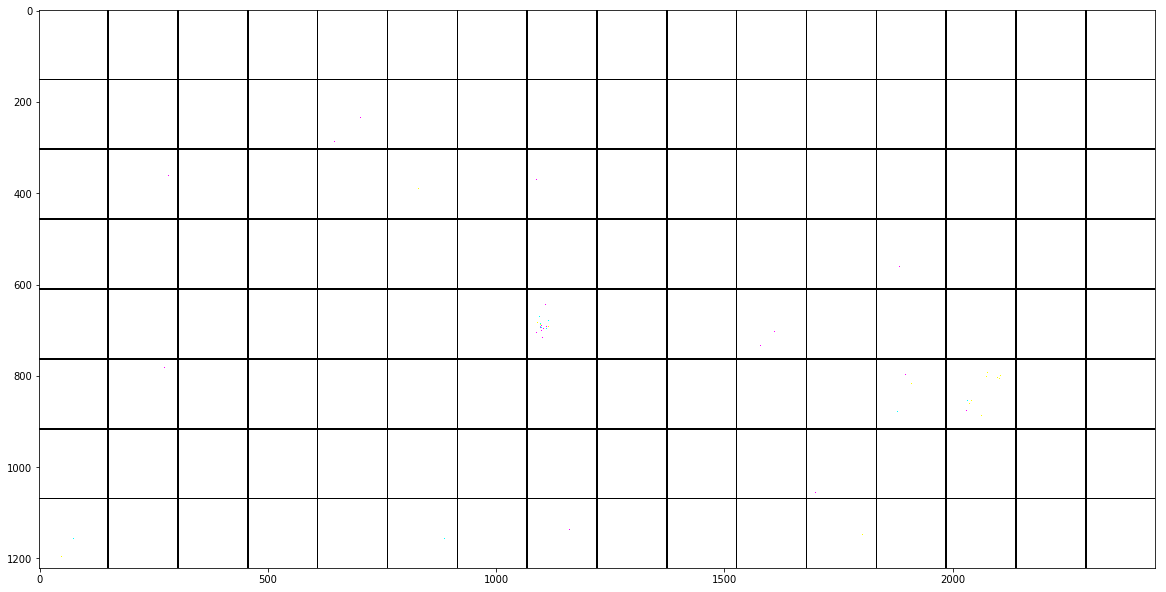

In [17]:
for layer_name in layers_name:
    #type(n_features)#=> <class 'tensorflow.python.framework.tensor_shape.Dimension'>
    n_features=model.get_layer(layer_name).output.shape[-1] #卷积核个数
    rows = n_features // images_per_row   #图像单元行数
    rows=rows.value
    cols=images_per_row                   #图像单元列数
  
    #初始化图像网格[rows{height} x cols{width}]
    display_grid = np.zeros((rows*img_height+(rows-1)*img_margin, cols * img_width+(cols-1)*img_margin,3))  

    # We'll tile each filter into this big horizontal grid
    print('Generating layer of %s ......'%(layer_name))
    pbar=ShowProcess(100)
    for row in range(rows):
        for col in range(cols):
            filter_index=row*cols+col
            filter_img = generate_pattern(model,layer_name, filter_index,steps=gen_pat_steps, img_width=img_width,img_height=img_height)
            row_start=row*img_height+row*img_margin
            row_end=row_start+img_height
            col_start=col*img_width+col*img_margin
            col_end=col_start+img_width
            #print(display_grid.shape)
            #print('row_start:%d,row_end:%d,col_start:%d,col_end:%d'%(row_start,row_end,col_start,col_end))            
            display_grid[row_start : row_end,col_start:col_end] = filter_img
            pbar.show_process((filter_index*100/(rows*cols)))
    pbar.show_process(100)
    # Display the results grid
    plt.figure(figsize=(20, 20))
    plt.imshow(display_grid)
    plt.show()    

# 可视化类激活的热力图

In [18]:
#图像预处理
def preprocess_input(x):
    #圖片預處理使用Keras applications 的 preprocess_input
    #https://medium.com/@sci218mike/%E5%9C%96%E7%89%87%E9%A0%90%E8%99%95%E7%90%86%E4%BD%BF%E7%94%A8keras-applications-%E7%9A%84-preprocess-input-6ef0963a483e
    return x/127.5 -1
    
#预测值解码
def decode_predictions(preds,class_indices_rev, top=3):
    print(preds)
    print(class_indices_rev)
    y=[class_indices_rev[0] if x <0.5 else class_indices_rev[1] for x in preds[:]]
    return y

[[0.17839517]]
{0: 'cat', 1: 'dog'}
Predicted: ['cat']


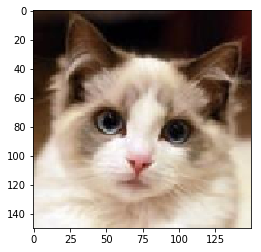

In [19]:
# The local path to our target image

# `img` is a PIL image of size 224x224
img = image.load_img(test_img_path, target_size=(img_height, img_width)) #加载测试图像

# `x` is a float32 Numpy array of shape (224, 224, 3)
x = image.img_to_array(img)  #转为numpy格式

# We add a dimension to transform our array into a "batch"
# of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0) #增加samples维

# Finally we preprocess the batch
# (this does channel-wise color normalization)
x = preprocess_input(x)  #图像数组预处理

preds = model.predict(x) #模型预测
class_indices_rev={v:k for k,v in test_gen.class_indices.items()}
print('Predicted:', decode_predictions(preds,class_indices_rev, top=3))

plt.figure()
plt.imshow(img)
plt.show() 

In [20]:
pred_index=np.argmax(preds[0])
# This is the "african elephant" entry in the prediction vector
african_elephant_output = model.output[:, pred_index]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer_name=layers_name[-1]
last_conv_layer = model.get_layer(last_conv_layer_name)

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (512,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `block5_conv3`,
# given a sample image
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([x])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the elephant class
for i in range(last_conv_layer.output.shape[-1]):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

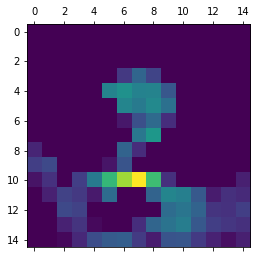

In [21]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

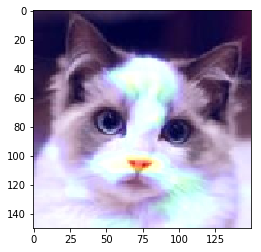

In [22]:
import cv2
# We use cv2 to load the original image
img = cv2.imread(test_img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# Save the image to disk
#cv2.imwrite('/Users/fchollet/Downloads/elephant_cam.jpg', superimposed_img)
img_hot_path='%s/test_hot.jpg'%(data_path)
cv2.imwrite(img_hot_path, superimposed_img)

img = image.load_img(img_hot_path, target_size=(img_height, img_width))
plt.figure()
plt.imshow(img)
plt.show() 

# 测试准确率

In [18]:
#测试准确率
y_pred=y_pred.reshape(y_pred.size,1)
print(type(y_pred))
print(y_pred.shape)
print(y_pred.dtype)
print(y_pred)

classes=test_gen.classes.reshape(test_gen.classes.size,1).astype('float32')
print(type(classes))
print(classes.shape)
print(classes.dtype)
print(classes)

y_pred[y_pred<0.5]=0
y_pred[y_pred>=0.5]=1
y_sub_abs=np.abs(classes-y_pred)
y_acc=1.0-y_sub_abs.sum()/y_sub_abs.size

print('test acc:%f'%(y_acc))
#print('y_pred.shape:%s'%(y_pred.size))
#print('classes.shape:%s'%(classes.size))
#print('y_pred:%s'%(y_pred))
#print('classes:%s'%(classes))
#print('y_sub_abs:%s'%(y_sub_abs))
#实验报告

<class 'numpy.ndarray'>
(5000, 1)
float32
[[9.9999917e-01]
 [9.9731356e-01]
 [3.0054528e-25]
 ...
 [1.0000000e+00]
 [9.5284245e-24]
 [1.0000000e+00]]
<class 'numpy.ndarray'>
(5000, 1)
float32
[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]
test acc:0.507000


# 测试代码